In [1]:
!git clone https://github.com/MrGrayTheET/futures_ml

Cloning into 'futures_ml'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 75 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (75/75), 182.73 KiB | 4.06 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [2]:
from futures_ml.utils import clean_arrays, sierra_charts as sc
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


In [5]:
from futures_ml import torch_dl
from futures_ml import chart_data_2 as cd2

/content/futures_ml/chart_data_2.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment.index = pd.to_datetime(sentiment.index)


In [10]:
cl_data = sc().format_sierra(pd.read_csv('/content/CL22-24.csv')).resample('4h').apply(sc().resample_logic)

In [48]:
cot = cd2.cot_data()

non_com_pos = cot.contract_data('CL_F')
new_pos_cols = ['long_pos', 'short_pos', 'long_chg', 'short_chg', 'pct_long', 'pct_short']

In [ ]:
!pip install pandas_ta

In [31]:
# prompt: Retrieve the item crude_oil_stock.csv and turn into a clean dataframe with floats using Pandas

df = pd.read_excel('/content/WCRSTUS1w.xls', sheet_name=1, skiprows=2)
df = df.rename(columns={'Sourcekey':'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df['crude_stock'] = df.iloc[:, 0]

In [49]:
import pandas_ta as ta
from futures_ml import feature_builder as fb

pre_mod = fb.model_prep(cl_data, ohlc=['Open', 'High', 'Low', 'Last'])
pre_mod.add_SMA(20)
pre_mod.add_daily_SMA(20)
pre_mod.add_daily_SMA(200)
pre_mod.bid_ask_vol_features()
pre_mod.supply_demand_zone(normalize=False, drop_non_normals=False)

pre_mod.wavelet_transform('db2', 4)
pre_mod.add_new_series(non_com_pos,cot.non_commercials[2:], new_pos_cols)
pre_mod.add_new_series(df, ['crude_stock'], ['crude_stock'])



2022-01-30 22:00:00         NaN
2022-01-31 00:00:00         NaN
2022-01-31 02:00:00         NaN
2022-01-31 04:00:00         NaN
2022-01-31 06:00:00         NaN
                         ...   
2022-04-14 04:00:00    411978.0
2022-04-14 06:00:00    411978.0
2022-04-14 08:00:00    411978.0
2022-04-14 10:00:00    411978.0
2022-04-14 12:00:00    411978.0
Freq: 2H, Name: long_pos, Length: 884, dtype: float64

In [39]:
features = ['Open', 'High', 'Low', 'Last', 'Volume', 'BidVolume', 'AskVolume',
        '20SMA', '20d_SMA', '200d_SMA','Delta',
       'avg_size', 'D1', 'D2', 'S1', 'S2', 'H-L', 'denoised', 'long_pos',
       'short_pos', 'long_chg', 'short_chg', 'pct_long', 'pct_short',
       'crude_stock']

In [52]:
[train_x, train_y], [test_x, test_y], y_scaler = clean_arrays(pre_mod.data, feats=features, target_col='Last',
                                                              sequence=True, periods_in=50, periods_out=16, scale_y=True, minmax_settings=(0,2),
                                                              to_tensor=True, return_y_scaler=True)

In [53]:
train_y = torch.reshape(train_y, (train_y.shape[0], train_y.shape[1]))
test_y = torch.reshape(test_y, (test_y.shape[0], test_y.shape[1]))

lr = 0.001
lstm = torch_dl.lstm(16, train_x.shape[2], 32, 1)
loss = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr)
n_epochs = 200

training_res = torch_dl.training_loop(n_epochs=n_epochs, lstm=lstm, optimizer=optimizer, loss_func=loss, X_train=train_x, y_train=train_y, X_test=test_x, y_test=test_y)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train_loss: 0.7831156253814697 test_loss: 0.3277294933795929
Epoch: 100, train_loss: 0.02567640319466591 test_loss: 0.018886670470237732


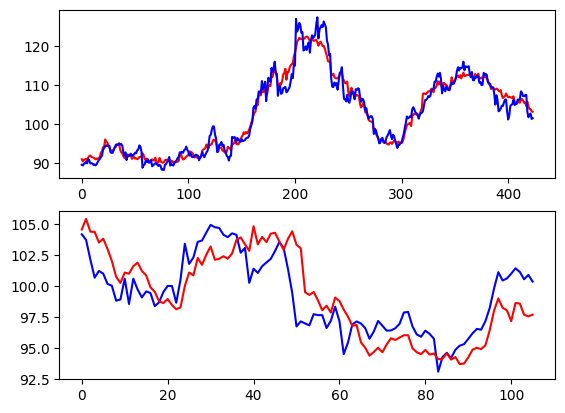

In [56]:
from futures_ml.utils import plot_predictions
plot_predictions(lstm(train_x), lstm(test_x), train_y, test_y, y_scaler)


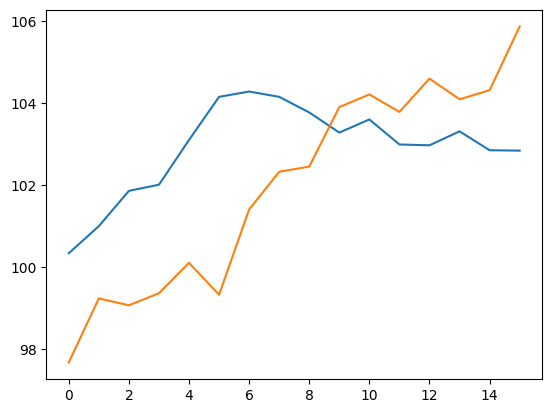

In [59]:
torch_dl.plot_final_prediction(test_x, test_y, y_scaler, lstm)

In [60]:
from futures_ml.utils import evaluate_model
evaluate_model(lstm(test_x).data.numpy(), test_y.data.numpy(), features, log_file='crude_lstm.log')

{'eval_datetime': [Timestamp('2024-07-25 20:26:53.957287')], 'r2_score': [-0.9287262006644033], 'mse': [0.047489174], 'rmse': [0.20750034], 'rmse/sd': [1.4370583], 'mape': [3.5667729377746583e-07], 'sorted_features': False, 'features': [['Open', 'High', 'Low', 'Last', 'Volume', 'BidVolume', 'AskVolume', '20SMA', '20d_SMA', '200d_SMA', 'Delta', 'avg_size', 'D1', 'D2', 'S1', 'S2', 'H-L', 'denoised', 'long_pos', 'short_pos', 'long_chg', 'short_chg', 'pct_long', 'pct_short', 'crude_stock']]}


/content/futures_ml/utils.py:126: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  log_df = pd.read_csv(log_file, index_col=['eval_datetime'], infer_datetime_format=True)


{'eval_datetime': [Timestamp('2024-07-25 20:26:53.957287')],
 'r2_score': [-0.9287262006644033],
 'mse': [0.047489174],
 'rmse': [0.20750034],
 'rmse/sd': [1.4370583],
 'mape': [3.5667729377746583e-07],
 'sorted_features': False,
 'features': [['Open',
   'High',
   'Low',
   'Last',
   'Volume',
   'BidVolume',
   'AskVolume',
   '20SMA',
   '20d_SMA',
   '200d_SMA',
   'Delta',
   'avg_size',
   'D1',
   'D2',
   'S1',
   'S2',
   'H-L',
   'denoised',
   'long_pos',
   'short_pos',
   'long_chg',
   'short_chg',
   'pct_long',
   'pct_short',
   'crude_stock']]}